## Women in Film & The Bechdel Test
* Emily J. Cain
* Capstone Project

In [1]:
import json
import numpy as np
import os
import pandas as pd
import plotly.graph_objs as go
import scipy.stats as stats
import tmdbsimple as tmdb

from bs4 import BeautifulSoup
from datetime import datetime
from get_path import path
from ratelimit import limits
from requests import get
from time import sleep, time
from warnings import warn

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
init_notebook_mode(connected=True)

## I. Data Collection & Cleaning

### Sources
#### Primary
* Bechdel Test Website - scraped
* TMDb API
* Wikidata SPARQL Queries

#### Supplemental
* Kaggle Datasets
* U.S. Census Bureau
* Motion Picture Association of America (MPAA)
* Women's Media Center (WMC)

### A. Bechdel Test Website
Scraped using Beautiful Soup to obtain:
* Name of movie
* Year
* Total points
    * 1 point for at least two named female characters ("Woman in Cafe #1", for example, would not qualify)
    * 2 points for named female characters who talk to each other
    * 3 points for named female characters who talk to each other about something other than a man
* Passing or Non-Passing (3 points = Passing)

In [83]:
# reset lists

years = []
movie_titles = []
test_scores = []
pass_or_no_pass = []
imdb_ids = []
imdb_links = []

start = time()
requests = 0

# first page will execute outside of loop due to different urls

base_url = 'https://bechdeltest.com/'
response = get(base_url)

# I swear I am not a robot beep boop beep
sleep(randint(8,15))

requests += 1
elapsed = time() - start
print(f'Request: {requests} Frequency: {round(requests/elapsed, 3)} requests/second')

# warning for non-200 status codes
if response.status_code != 200:
    warn(f'Request: {requests} Status code: {response.status_code}')
    
soup = BeautifulSoup(response.text, 'html.parser')
movies = soup.findAll('div', {'class': 'movie'})

for movie in movies:
    
    year = movie.find_previous('h3').a['id'].split('-')[1]
    years.append(int(year))
    
    title = movie.contents[2].text.strip()
    movie_titles.append(title)
    
    test_score = movie.a.img['alt'][2]
    test_scores.append(int(test_score))
    
    passing = movie.a.img['src'].split('/')[2].split('.')[0]
    pass_or_no_pass.append(passing)
    
    imdb_id = movie.a['href'].split('/')[4]
    imdb_ids.append(imdb_id)
    
    imdb_link = movie.a['href']
    imdb_links.append(imdb_link)
    
# now start with page 1
pages = [str(i) for i in range(1,41)]

for page in pages:
    
    response = get(base_url + '?page=' + page)
    
    # repeat sleeping, print statements, and warnings
    sleep(randint(8,15))

    requests += 1
    elapsed = time() - start
    print(f'Request: {requests} Frequency: {round(requests/elapsed, 3)} requests/second')

    
    if response.status_code != 200:
        warn(f'Request: {requests} Status code: {response.status_code}')
        
    if requests > 42:
        warn('Number of requests greater than expected.')
        break
    
    soup = BeautifulSoup(response.text, 'html.parser')
    movies = soup.findAll('div', {'class': 'movie'})
    
    for movie in movies:
        
        year = movie.find_previous('h3').a['id'].split('-')[1]
        years.append(int(year))
    
        title = movie.contents[2].text.strip()
        movie_titles.append(title)
    
        test_score = movie.a.img['alt'][2]
        test_scores.append(int(test_score))
    
        passing = movie.a.img['src'].split('/')[2].split('.')[0]
        pass_or_no_pass.append(passing)
    
        imdb_id = movie.a['href'].split('/')[4]
        imdb_ids.append(imdb_id)
    
        imdb_link = movie.a['href']
        imdb_links.append(imdb_link)

Request: 1 Frequency: 0.065 requests/second
Request: 2 Frequency: 0.064 requests/second
Request: 3 Frequency: 0.062 requests/second
Request: 4 Frequency: 0.067 requests/second
Request: 5 Frequency: 0.068 requests/second
Request: 6 Frequency: 0.067 requests/second
Request: 7 Frequency: 0.068 requests/second
Request: 8 Frequency: 0.066 requests/second
Request: 9 Frequency: 0.066 requests/second
Request: 10 Frequency: 0.065 requests/second
Request: 11 Frequency: 0.064 requests/second
Request: 12 Frequency: 0.064 requests/second
Request: 13 Frequency: 0.064 requests/second
Request: 14 Frequency: 0.064 requests/second
Request: 15 Frequency: 0.064 requests/second
Request: 16 Frequency: 0.065 requests/second
Request: 17 Frequency: 0.066 requests/second
Request: 18 Frequency: 0.065 requests/second
Request: 19 Frequency: 0.065 requests/second
Request: 20 Frequency: 0.065 requests/second
Request: 21 Frequency: 0.065 requests/second
Request: 22 Frequency: 0.066 requests/second
Request: 23 Frequen

In [67]:
bechdel_df_to_analyze_crew_genders = pd.read_csv('my_data/condensed_bechdel_7.csv')
bechdel_df_to_analyze_crew_genders.head()

,year,title,passing,director,writer,producer,overall
0,2019.0,Alita: Battle Angel,1,0.0,1.0,0,1.0
1,2019.0,Close,1,1.0,1.0,0,2.0
2,2019.0,Cold Pursuit,0,0.0,0.0,0,0.0
3,2019.0,The Kid Who Would Be King,0,0.0,0.0,1,1.0
4,2019.0,Polar,0,0.0,0.0,0,0.0


In [69]:
bechdel_df_to_analyze_crew_genders.shape

(7571, 7)

In [68]:
bechdel_df_to_analyze_budgets_revenues = pd.read_csv('my_data/non_zero_budgets_revenues_3.csv')
bechdel_df_to_analyze_budgets_revenues.head()

,year,title,score,passing,imdb_id,director_gender,writer_gender,producer_gender,overall_gender,budget_millions,revenue_millions
0,2019.0,alita: battle angel,3.0,1.0,tt0437086,0.0,1.0,0,1.0,170.0,359.700000
1,2018.0,a quiet place,1.0,0.0,tt6644200,0.0,0.0,0,0.0,17.0,340.939361
2,2018.0,a simple favor,3.0,1.0,tt7040874,0.0,1.0,1,2.0,20.0,42.600000
3,2018.0,a star is born,3.0,1.0,tt1517451,0.0,1.0,0,1.0,36.0,403.588149
4,2018.0,a wrinkle in time,3.0,1.0,tt1620680,1.0,1.0,1,3.0,100.0,132.675864


In [70]:
bechdel_df_to_analyze_budgets_revenues.shape

(3461, 11)

In [72]:
print(bechdel_df_to_analyze_budgets_revenues.isnull().sum())
print(bechdel_df_to_analyze_crew_genders.isnull().sum())

year                0
title               0
score               0
passing             0
imdb_id             0
director_gender     0
writer_gender       0
producer_gender     0
overall_gender      0
budget_millions     0
revenue_millions    0
dtype: int64
year        0
title       0
passing     0
director    0
writer      0
producer    0
overall     0
dtype: int64


### B. TMDb (The Movie Database) API
* Final API calls made with
    * `requests`
    * `get`
    * ratelimit wrapper
   

* The tmdbsimple library was not ultimately used due to inability to easily limit requests according to API guidelines

#### Import API Key

In [8]:
with open(path) as f:
    data = json.load(f)

In [9]:
tmdb.API_KEY = data['key']

In [10]:
api_key = data['key']

#### tmdbsimple wrapper

##### Title Query - basic movie info

In [8]:
search = tmdb.Search()
response = search.movie(query='How to Train Your Dragon: The Hidden World')
for s in search.results:
    print(s)

{'vote_count': 993, 'id': 166428, 'video': False, 'vote_average': 7.8, 'title': 'How to Train Your Dragon: The Hidden World', 'popularity': 310.039, 'poster_path': '/xvx4Yhf0DVH8G4LzNISpMfFBDy2.jpg', 'original_language': 'en', 'original_title': 'How to Train Your Dragon: The Hidden World', 'genre_ids': [16, 10751, 12], 'backdrop_path': '/h3KN24PrOheHVYs9ypuOIdFBEpX.jpg', 'adult': False, 'overview': 'As Hiccup fulfills his dream of creating a peaceful dragon utopia, Toothless’ discovery of an untamed, elusive mate draws the Night Fury away. When danger mounts at home and Hiccup’s reign as village chief is tested, both dragon and rider must make impossible decisions to save their kind.', 'release_date': '2019-01-03'}


##### TMDb id - movie details

In [9]:
response = tmdb.Movies(166428).info()

In [10]:
response

{'adult': False,
 'backdrop_path': '/h3KN24PrOheHVYs9ypuOIdFBEpX.jpg',
 'belongs_to_collection': {'id': 89137,
  'name': 'How to Train Your Dragon Collection',
  'poster_path': '/4tBKIkPLFMkiZETjAMOHNoty8B1.jpg',
  'backdrop_path': '/mvcfPkOvgDJG2lEAxTz0NKqoQLo.jpg'},
 'budget': 129000000,
 'genres': [{'id': 16, 'name': 'Animation'},
  {'id': 10751, 'name': 'Family'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.howtotrainyourdragon.com/',
 'id': 166428,
 'imdb_id': 'tt2386490',
 'original_language': 'en',
 'original_title': 'How to Train Your Dragon: The Hidden World',
 'overview': 'As Hiccup fulfills his dream of creating a peaceful dragon utopia, Toothless’ discovery of an untamed, elusive mate draws the Night Fury away. When danger mounts at home and Hiccup’s reign as village chief is tested, both dragon and rider must make impossible decisions to save their kind.',
 'popularity': 310.039,
 'poster_path': '/xvx4Yhf0DVH8G4LzNISpMfFBDy2.jpg',
 'production_companies':

#### Requests with no wrapper

##### Custom Functions

In [ ]:
@limits(calls=40, period=10)
def call_api(url):
    """
    Function takes url as argument, checks status code, and returns response.
    Ratelimit wrapper used to adhere to TMDb API guideline of no more than 40 calls in 10 seconds.
    """
    response = get(url)
    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response

##### Test Function

In [122]:
# test list
imdb_id_list = ['tt5316540', 'tt5719748', 'tt2386490']
movie_pages = []
for imdb_id in imdb_id_list:
    url = 'https://api.themoviedb.org/3/find/' + imdb_id + '?api_key=' + api_key + '&external_source=imdb_id'
    response = call_api(url)
    movie_pages.append(response.json())

In [123]:
movie_pages

[{'movie_results': [{'adult': False,
    'backdrop_path': '/j7n2zYUODG8ViBSq7VyXyGlwJfH.jpg',
    'genre_ids': [28, 53],
    'id': 460321,
    'original_language': 'en',
    'original_title': 'Close',
    'overview': 'A counter-terrorism expert takes a job protecting a young heiress. After an attempted kidnapping puts both of their lives in danger, they must flee.',
    'poster_path': '/gDvJFHJCVXce4SVDsbLOqUk9sKQ.jpg',
    'release_date': '2019-01-18',
    'title': 'Close',
    'video': False,
    'vote_average': 5.6,
    'vote_count': 222,
    'popularity': 23.585}],
  'person_results': [],
  'tv_results': [],
  'tv_episode_results': [],
  'tv_season_results': []},
 {'movie_results': [{'adult': False,
    'backdrop_path': '/7Wg6FOEvhduISlxSzSCutAl4lPq.jpg',
    'genre_ids': [53, 28, 18],
    'id': 438650,
    'original_language': 'en',
    'original_title': 'Cold Pursuit',
    'overview': "Nels Coxman's quiet life comes crashing down when his beloved son dies under mysterious circums

#### Use `for` loops to use imdb ids from Bechdel Test dataset to get budget and revenue values

In [ ]:
imdb_id_list = imdb_ids
movie_pages = []
tmdb_ids = []
budgets = {}
revenues = {}
bad_ids = []

In [196]:
start = datetime.now()

for imdb_id in imdb_id_list:
    
    url = 'https://api.themoviedb.org/3/find/' + imdb_id + '?api_key=' + api_key + '&external_source=imdb_id'
    response = call_api(url)
    movie_info = response.json()
    if movie_info['movie_results']:
        movie_pages.append(movie_info)
    else:
        print(f'No info for {imdb_id}')
        bad_ids.append(imdb_id)
        
elapsed = start - datetime.now()
print(f'Total time: {elapsed}')

No info for tt5861756
No info for tt
No info for tt
No info for tt5598192
No info for tt5833846
No info for tt7341676
No info for tt6524480
No info for tt5675620
No info for tt5997830
No info for tt4956232
No info for tt4270492
No info for tt4869556
No info for tt4644822
No info for tt5709236
No info for tt5022298
No info for tt6220550
No info for tt2938496
No info for tt5580664
No info for tt4000768
No info for tt4108134
No info for tt4498966
No info for tt4895704
No info for tt6663788
No info for tt4780834
No info for tt2431438
No info for tt4858280
No info for tt2742544
No info for tt3749900
No info for tt3638604
No info for tt4211680
No info for tt3566726
No info for tt3457342
No info for tt3630276
No info for tt2964334
No info for tt3448098
No info for tt2294189
No info for tt2991316
No info for tt2309295
No info for tt1856010
No info for tt191181
No info for tt2628260
No info for tt2520512
No info for tt2407574
No info for tt2234222
No info for tt3066242
No info for tt2255372
No 

In [197]:
len(movie_pages)

7961

In [198]:
len(bad_ids)

128

In [199]:
bad_ids_df = pd.Series(data=bad_ids)
bad_ids_df.head()

0    tt5861756
1           tt
2           tt
3    tt5598192
4    tt5833846
dtype: object

Bad ids were used to check for TV shows, other type of media that wouldn't have come up in API search for movies, and incorrect data. 

In [202]:
for movie in movie_pages:
    tmdb_ids.append(movie['movie_results'][0]['id'])

In [204]:
start = datetime.now()

for tmdb_id in tmdb_ids:
    url = 'https://api.themoviedb.org/3/movie/' + str(tmdb_id) + '?api_key=' + api_key
    response = call_api(url)
    movie_details = response.json()
    imdb_id = movie_details['imdb_id']
    budgets[imdb_id] = movie_details['budget']
    revenues[imdb_id] = movie_details['revenue']
    
elapsed = datetime.now() - start
print(f'Total time: {elapsed}')

Total time: 0:49:08.690481


In [206]:
budget_df = pd.DataFrame.from_dict(data=budgets, orient='index')
revenue_df = pd.DataFrame.from_dict(data=revenues, orient='index')

### C. Wikidata SPARQL Queries
* Used to find movies that had a Bechdel Test id to obtain (if available):
    * Director(s) Name & Gender
    * Screenwriter(s) Name & Gender
    * Producer(s) Name & Gender
    * Film Budget
    * Box Office Revenue
    
    
* Used for Academy Awards queries to obtain (if available):
    * Nominees and Winners for all current and defunct non-acting categories
    * Names
    * Genders
    * Year of Awards show

### Custom Functions Used

In [ ]:
def clean_up(sparql_df):
    
    """
    The function takes a pandas dataframe derived from a downloaded SPARQL query csv and returns a new dataframe. 
    If there are any values of female, non-binary, or transgender in the director, writer, or producer columns for a movie, 
    then that movie is assigned a value of 1 for that crew position. A new overall column is added which tracks how many crew 
    positions for that movie contained a person of an underrepresented gender. Original name and gender columns are dropped, as
    are any duplicate rows based on movie title.
    """
    
    new_director_values = [1 if val == True else 0 for val in sparql_df.directorGender.str.contains('female|non-binary|transgender')]
    new_writer_values = [1 if val == True else 0 for val in sparql_df.screenwriterGender.str.contains('female|non-binary|transgender')]
    new_exec_values = [1 if val == True else 0 for val in sparql_df.executiveproducerGender.str.contains('female|non-binary|transgender')]
    new_producer_values = [1 if val == True else 0 for val in sparql_df.producerGender.str.contains('female|non-binary|transgender')]
    
    sparql_df['director_fnbt'] = new_director_values
    sparql_df['writer_fnbt'] = new_writer_values
    sparql_df['exec_fnbt'] = new_exec_values
    sparql_df['producer_fnbt'] = new_producer_values
    
    sparql_df['overall_fnbt'] = sparql_df['director_fnbt'] + sparql_df['writer_fnbt'] + sparql_df['exec_fnbt'] + sparql_df['producer_fnbt']
    
    cols_to_drop = ['directorName', 'directorGender', 'screenwriterName', 'screenwriterGender', 'executiveproducerName',\
               'executiveproducerGender', 'producerName', 'producerGender']
    sparql_df.drop(columns=cols_to_drop, axis=1, inplace=True)
    sparql_df.sort_values('overall_fnbt', ascending=False, inplace=True)
    sparql_df.drop_duplicates('movieTitle', inplace=True)
    sparql_df.sort_index(inplace=True)
    return sparql_df

##### Multiple SPARQL queries were downloaded, cleaned, and merged without many matching movies to the Bechdel Test dataset. The best query ended up using a Bechdel Test id as a requirement for inclusion in the dataset. 

In [33]:
new_bechdel_query.head()

,movieTitle,directorName,directorGender,screenwriterName,screenwriterGender,executiveproducerName,executiveproducerGender,producerName,producerGender,budgetAmount,boxofficeAmount,imdbId
0,Independence Day,Roland Emmerich,male,Roland Emmerich,male,Ute Emmerich,female,Roland Emmerich,male,NaN,817400891.0,tt0116629
1,Independence Day,Roland Emmerich,male,Roland Emmerich,male,Ute Emmerich,female,Dean Devlin,male,NaN,817400891.0,tt0116629
2,Independence Day,Roland Emmerich,male,Roland Emmerich,male,Roland Emmerich,male,Roland Emmerich,male,NaN,817400891.0,tt0116629
3,Independence Day,Roland Emmerich,male,Roland Emmerich,male,Roland Emmerich,male,Dean Devlin,male,NaN,817400891.0,tt0116629
4,Independence Day,Roland Emmerich,male,Dean Devlin,male,Ute Emmerich,female,Roland Emmerich,male,NaN,817400891.0,tt0116629


In [34]:
clean_up(new_bechdel_query)

,movieTitle,budgetAmount,boxofficeAmount,imdbId,director_fnbt,writer_fnbt,exec_fnbt,producer_fnbt,overall_fnbt
10004,The Dark Crystal,NaN,NaN,tt0083791,0,0,0,0,0
10005,The Thin Man Goes Home,NaN,NaN,tt0037365,0,0,0,0,0
10007,Picture Perfect,NaN,NaN,tt0119896,0,1,0,0,1
10009,The Cruel Sea,NaN,NaN,tt0045659,0,0,0,0,0
10010,Our Hospitality,NaN,NaN,tt0014341,0,0,0,0,0
10015,Little Caesar,NaN,NaN,tt0021079,0,0,0,0,0
10016,The Long Walk Home,NaN,NaN,tt0100046,0,0,0,0,0
10017,Cléo from 5 to 7,NaN,NaN,tt0055852,1,1,0,0,2
10018,The Spanish Gardener,NaN,NaN,tt0049787,0,0,0,0,0
10021,Antitrust,NaN,NaN,tt0218817,0,0,0,0,0


##### Check for shared imdb ids in query datasets and the Bechdel Test dataset.

In [2]:
bechdel_df = pd.read_csv('my_data/bechdel_test_movies.csv')
bechdel_df.head()

,year,title,score,passing,imdb_id,imdb_link
0,2019,Alita: Battle Angel,3,1,tt0437086,http://us.imdb.com/title/tt0437086/
1,2019,American Woman,3,1,tt9109492,http://us.imdb.com/title/tt9109492/
2,2019,Close,3,1,tt5316540,http://us.imdb.com/title/tt5316540/
3,2019,Cold Pursuit,1,0,tt5719748,http://us.imdb.com/title/tt5719748/
4,2019,How to Train Your Dragon: The Hidden World,2,0,tt2386490,http://us.imdb.com/title/tt2386490/


In [3]:
bechdel_df.drop('imdb_link', axis=1, inplace=True)

In [4]:
bechdel_df.tail()

,year,title,score,passing,imdb_id
8045,1896,Une nuit terrible,0,0,tt0000131
8046,1895,"The Execution of Mary, Queen of Scots",0,0,tt0132134
8047,1895,Tables Turned on the Gardener,0,0,tt0000014
8048,1892,Pauvre Pierrot,0,0,tt0000003
8049,1888,Roundhay Garden Scene,0,0,tt0392728


In [5]:
all_the_movies = pd.read_csv('my_data/movies_cleaned_with_new_columns.csv')
all_the_movies.head()

,Unnamed: 0,movieTitle,budgetAmount,boxofficeAmount,imdbId,director_fnbt,writer_fnbt,exec_fnbt,producer_fnbt,overall_fnbt
0,0,Fast Five,NaN,626100000.0,tt1596343,0,0,0,0,0
1,1,Albert Nobbs,NaN,NaN,tt1602098,0,1,0,1,2
2,2,Lore,NaN,NaN,tt1996310,1,1,0,1,3
3,3,Get the Gringo,NaN,NaN,tt1567609,0,0,0,0,0
4,4,Airborne,NaN,NaN,tt1827354,0,0,0,0,0


In [6]:
all_the_movies.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
all_the_movies.tail()

,movieTitle,budgetAmount,boxofficeAmount,imdbId,director_fnbt,writer_fnbt,exec_fnbt,producer_fnbt,overall_fnbt
54559,Foolish Wives,NaN,NaN,tt0013140,0,0,0,0,0
54560,Cairo,NaN,NaN,tt0034565,0,0,0,0,0
54561,The Vanishing Legion,NaN,NaN,tt0022531,0,0,0,0,0
54562,The Citadel,NaN,NaN,tt0029995,0,1,0,0,1
54563,Things to Come,NaN,NaN,tt0028358,0,0,0,0,0


In [8]:
bechdel_ids = bechdel_df.imdb_id.values
the_other_ids = all_the_movies.imdbId.values

In [9]:
shared_ids = set(bechdel_ids) & set(the_other_ids)
len(shared_ids)

5471

In [14]:
missing_movies = []
for bechdel_id in bechdel_ids:
    if bechdel_id not in list(shared_ids):
        missing_movies.append(bechdel_id)

In [15]:
len(missing_movies)

2577

In [17]:
bechdel_df.shape

(8050, 5)

In [35]:
new_query_ids = new_bechdel_query.imdbId.values

In [36]:
shared_ids = set(bechdel_ids) & set(new_query_ids)
len(shared_ids)

7147

##### The new query dataset was used to merge with Bechdel Test dataset

In [37]:
bechdel_appended = bechdel_df.merge(new_bechdel_query, left_on='imdb_id', right_on='imdbId', how='outer')

In [38]:
bechdel_appended.head()

,year,title,score,passing,imdb_id,movieTitle,budgetAmount,boxofficeAmount,imdbId,director_fnbt,writer_fnbt,exec_fnbt,producer_fnbt,overall_fnbt
0,2019.0,Alita: Battle Angel,3.0,1.0,tt0437086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019.0,American Woman,3.0,1.0,tt9109492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019.0,Close,3.0,1.0,tt5316540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019.0,Cold Pursuit,1.0,0.0,tt5719748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019.0,How to Train Your Dragon: The Hidden World,2.0,0.0,tt2386490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
bechdel_appended.shape

(8064, 14)

In [40]:
bechdel_appended.isnull().sum()

year                 14
title                14
score                14
passing              14
imdb_id              14
movieTitle          900
budgetAmount       7157
boxofficeAmount    6892
imdbId              906
director_fnbt       900
writer_fnbt         900
exec_fnbt           900
producer_fnbt       900
overall_fnbt        900
dtype: int64

##### Other movie datasets were downloaded from Kaggle to find and supplement missing values (using imdb ids to find matching movies) - particularly for budget and revenue, but using multiple data sources collected in different ways by different people did introduce problems for the project. 

##### Final Bechdel Dataset
* no null values (but still contained some zero values)
* combined executive producer and producer columns
* changed `fnbt` (representing cisgender female, non-binary, and transgender males and females as overall group of underrepresented genders) to `gender`

##### Final Bechdel Dataset with Budget and Revenue
* movies with zero values for budget or revenue were dropped
* budget and revenues were scaled by millions

In [56]:
final_bechdel_with_nulls = pd.read_csv('my_data/bechdel_before_dropping_nulls.csv')
final_bechdel_with_nulls.head()

,year,title,score,passing,imdb_id,director_fnbt,writer_fnbt,exec_fnbt,producer_fnbt,overall_fnbt,new_budgets,new_revenues
0,2019.0,Alita: Battle Angel,3.0,1.0,tt0437086,0.0,1.0,0.0,0.0,1.0,170000000.0,359700000.0
1,2019.0,American Woman,3.0,1.0,tt9109492,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2019.0,Close,3.0,1.0,tt5316540,1.0,1.0,0.0,0.0,2.0,0.0,0.0
3,2019.0,Cold Pursuit,1.0,0.0,tt5719748,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019.0,How to Train Your Dragon: The Hidden World,2.0,0.0,tt2386490,NaN,NaN,NaN,NaN,NaN,129000000.0,375396270.0


In [57]:
final_bechdel_with_nulls.isnull().sum()

year               0
title              0
score              0
passing            0
imdb_id            0
director_fnbt    399
writer_fnbt      399
exec_fnbt        399
producer_fnbt    399
overall_fnbt     399
new_budgets        0
new_revenues       0
dtype: int64

In [58]:
final_bechdel_no_nulls = pd.read_csv('my_data/lowercase_bechdel_7.csv')
final_bechdel_no_nulls.head()

,year,title,score,passing,imdb_id,director_gender,writer_gender,producer_gender,overall_gender,budget,revenue
0,2019.0,alita: battle angel,3.0,1.0,tt0437086,0.0,1.0,0,1.0,170000000.0,359700000.0
1,2019.0,close,3.0,1.0,tt5316540,1.0,1.0,0,2.0,0.0,0.0
2,2019.0,cold pursuit,1.0,0.0,tt5719748,0.0,0.0,0,0.0,0.0,0.0
3,2019.0,the kid who would be king,1.0,0.0,tt6811018,0.0,0.0,1,1.0,0.0,0.0
4,2019.0,polar,2.0,0.0,tt4139588,0.0,0.0,0,0.0,0.0,0.0


In [59]:
final_bechdel_no_nulls.shape

(7571, 11)

In [60]:
final_bechdel_non_zero_values = pd.read_csv('my_data/non_zero_budgets_revenues_3.csv')
final_bechdel_non_zero_values.head()

,year,title,score,passing,imdb_id,director_gender,writer_gender,producer_gender,overall_gender,budget_millions,revenue_millions
0,2019.0,alita: battle angel,3.0,1.0,tt0437086,0.0,1.0,0,1.0,170.0,359.700000
1,2018.0,a quiet place,1.0,0.0,tt6644200,0.0,0.0,0,0.0,17.0,340.939361
2,2018.0,a simple favor,3.0,1.0,tt7040874,0.0,1.0,1,2.0,20.0,42.600000
3,2018.0,a star is born,3.0,1.0,tt1517451,0.0,1.0,0,1.0,36.0,403.588149
4,2018.0,a wrinkle in time,3.0,1.0,tt1620680,1.0,1.0,1,3.0,100.0,132.675864


In [61]:
final_bechdel_non_zero_values.shape

(3461, 11)

#### Academy Awards Data - Nominees

In [8]:
oscar_nominees = pd.read_csv('my_data/oscarnomineesnobestpic.csv')
oscar_nominees.head()

,humanLabel,genderLabel,nominationLabel,year
0,Charlie Chaplin,male,"Academy Award for Best Writing, Original Scree...",1948
1,Charlie Chaplin,male,"Academy Award for Best Writing, Original Scree...",1941
2,Peter Jackson,male,"Academy Award for Best Writing, Original Scree...",1995
3,Michel Hazanavicius,male,"Academy Award for Best Writing, Original Scree...",2012
4,Sylvester Stallone,male,"Academy Award for Best Writing, Original Scree...",1977


#### Check unique gender values

In [9]:
oscar_nominees.genderLabel.value_counts()

male          8543
female        1025
non-binary       1
Name: genderLabel, dtype: int64

In [10]:
oscar_nominees.query('genderLabel == "non-binary"')

,humanLabel,genderLabel,nominationLabel,year
3058,Sam Smith,non-binary,Academy Award for Best Original Song,2016


In [11]:
oscar_nominees.shape

(9600, 4)

In [8]:
oscar_nominees.nominationLabel.value_counts()

Academy Award for Best Sound Mixing                         1049
Academy Award for Best Production Design                     731
Academy Award for Best Writing, Adapted Screenplay           661
Academy Award for Best Writing, Original Screenplay          623
Academy Award for Best Film Editing                          542
Academy Award for Best Visual Effects                        504
Academy Award for Best Director                              442
Academy Award for Best Animated Short Film                   425
Academy Award for Best Documentary (Short Subject)           411
Academy Award for Best Art Direction, Black and White        380
Academy Award for Best Live Action Short Film                379
Academy Award for Best Art Direction, Color                  371
Academy Award for Best Cinematography                        320
Academy Award for Best Costume Design                        289
Academy Award for Best Original Score                        283
Academy Award for Best Ma

#### Custom Functions Used

In [12]:
def condense_categories(category_string):
    
    """
    Function takes an Academy Award category string from Wikidata query and returns the useful information in new string.
    For example, the original argument of 'Academy Award for Best Original Song' would return 'Original Song'
    """
    
    split_category_string = category_string.split(' ')
    condensed_category_string = split_category_string[4:]
    return ' '.join(condensed_category_string)

In [13]:
def clean_oscar_sparql_query(df, award_column, new_award_column):
    
    """
    Function takes DataFrame generated from Wikidata query, the string value of the award_column name, the new desired string 
    value for the award_column and returns new DataFrame. The condense_categories function is applied to the values in the awards
    column, and the humanLabel, genderLabel, and award_column are renamed to name, gender, and new_award_column, respectively.
    """
    
    df[award_column] = df[award_column].map(condense_categories)
    df.rename({'humanLabel': 'name', 'genderLabel': 'gender', award_column: new_award_column}, axis=1, inplace=True)
    return df

In [14]:
clean_oscar_sparql_query(oscar_nominees, award_column='nominationLabel', new_award_column='nom_category')

,name,gender,nom_category,year
0,Charlie Chaplin,male,"Writing, Original Screenplay",1948
1,Charlie Chaplin,male,"Writing, Original Screenplay",1941
2,Peter Jackson,male,"Writing, Original Screenplay",1995
3,Michel Hazanavicius,male,"Writing, Original Screenplay",2012
4,Sylvester Stallone,male,"Writing, Original Screenplay",1977
5,Melvin Frank,male,"Writing, Original Screenplay",1974
6,Melvin Frank,male,"Writing, Original Screenplay",1955
7,Melvin Frank,male,"Writing, Original Screenplay",1961
8,Melvin Frank,male,"Writing, Original Screenplay",1947
9,Arthur C. Clarke,male,"Writing, Original Screenplay",1969


In [15]:
oscar_nominees.head()

,name,gender,nom_category,year
0,Charlie Chaplin,male,"Writing, Original Screenplay",1948
1,Charlie Chaplin,male,"Writing, Original Screenplay",1941
2,Peter Jackson,male,"Writing, Original Screenplay",1995
3,Michel Hazanavicius,male,"Writing, Original Screenplay",2012
4,Sylvester Stallone,male,"Writing, Original Screenplay",1977


In [16]:
oscar_nominees.tail()

,name,gender,nom_category,year
9595,Thomas Mead,male,"Live Action Short Film, Two-Reel",1949
9596,Ben K. Blake,male,"Live Action Short Film, Two-Reel",1948
9597,William Lasky,male,"Live Action Short Film, Two-Reel",1950
9598,Louis Harris,male,"Live Action Short Film, Two-Reel",1945
9599,John Healy,male,"Live Action Short Film, Two-Reel",1957


#### Check for null values

In [43]:
oscar_nominees.isnull().sum()

name             0
gender          30
nom_category     0
year             0
dtype: int64

In [44]:
null_genders = oscar_nominees.loc[oscar_nominees.gender.isnull()]
null_genders

,name,gender,nom_category,year
2434,Jocelyn Glatzer,NaN,Documentary Feature,2007
3755,Ariel Velasco-Shaw,NaN,Visual Effects,1994
4043,Lyle Conway,NaN,Visual Effects,1987
4117,Thaine Morris,NaN,Visual Effects,1989
4118,Kent Houston,NaN,Visual Effects,1990
6526,Eda Godel Hallinan,NaN,Animated Short Film,1984
6640,Jan Saunders,NaN,Live Action Short Film,1983
6646,Thom Colwell,NaN,Live Action Short Film,1996
6649,Gabriele Lins,NaN,Live Action Short Film,2000
6712,T.R. Conroy,NaN,Live Action Short Film,1992


In [ ]:
# look up genders to add later or drop if unknown

#### Save cleaned dataset to new csv

In [42]:
oscar_nominees.to_csv('my_data/cleaned_oscar_nominees.csv', index=False)

#### Academy Awards Data - Winners

In [18]:
oscar_winners = pd.read_csv('my_data/oscarwinnersquerynobestpicture.csv')
oscar_winners.head()

,humanLabel,genderLabel,awardLabel,year
0,Peter Jackson,male,Academy Award for Best Director,2004
1,Steven Spielberg,male,Academy Award for Best Director,1999
2,Steven Spielberg,male,Academy Award for Best Director,1994
3,Kevin Costner,male,Academy Award for Best Director,1991
4,Woody Allen,male,Academy Award for Best Director,1978


In [19]:
oscar_winners.genderLabel.unique()

array(['male', 'female', nan], dtype=object)

#### Check for null values

In [23]:
oscar_winners.isnull().sum()

humanLabel     0
genderLabel    2
awardLabel     0
year           0
dtype: int64

In [24]:
oscar_winners.loc[oscar_winners.genderLabel.isnull()]

,humanLabel,genderLabel,awardLabel,year
720,Robie Robinson,NaN,Academy Award for Best Visual Effects,1970
1507,Gerardine Wurzburg,NaN,Academy Award for Best Documentary (Short Subj...,1993


Cannot find information online for Robie Robinson, so will drop from both datasets. 

In [25]:
oscar_nominees = oscar_nominees.loc[oscar_nominees.name != 'Robie Robinson']
oscar_winners = oscar_winners.loc[oscar_winners.humanLabel != 'Robie Robinson']

In [34]:
oscar_winners.at[1507,'genderLabel'] = 'female'

In [37]:
oscar_winners.isnull().sum()

humanLabel     0
genderLabel    0
awardLabel     0
year           0
dtype: int64

#### Apply cleaning functions

In [38]:
clean_oscar_sparql_query(oscar_winners, award_column='awardLabel', new_award_column='win_category')

,name,gender,win_category,year
0,Peter Jackson,male,Director,2004
1,Steven Spielberg,male,Director,1999
2,Steven Spielberg,male,Director,1994
3,Kevin Costner,male,Director,1991
4,Woody Allen,male,Director,1978
5,Alfonso Cuarón,male,Director,2014
6,Michel Hazanavicius,male,Director,2012
7,Kathryn Bigelow,female,Director,2010
8,Mel Gibson,male,Director,1996
9,Clint Eastwood,male,Director,1993


In [39]:
oscar_winners.shape

(2056, 4)

In [40]:
oscar_winners.tail()

,name,gender,win_category,year
2052,Jerry Fairbanks,male,"Live Action Short Film, One-Reel",1945
2053,Sam Coslow,male,"Live Action Short Film, Two-Reel",1944
2054,Boris Vermont,male,"Live Action Short Film, One-Reel",1953
2055,Konstantin Kalser,male,"Live Action Short Film, One-Reel",1957
2056,Wilbur T. Blume,male,"Live Action Short Film, Two-Reel",1956


#### Save new cleaned dataset to csv

In [41]:
oscar_winners.to_csv('my_data/cleaned_oscar_winners.csv', index=False)

## II. Exploratory Data Analysis & Visualizations

### A. Bechdel Test Data
* Distribution of Scores
* Distribution of Passing vs. Non-Passing Movies

In [85]:
bechdel_df = pd.read_csv('my_data/bechdel_8_for_datatable.csv')
bechdel_df.head()

,year,title,score,passing,director,writer,producer,overall
0,2019.0,Alita: Battle Angel,3.0,1.0,0.0,1.0,0,1.0
1,2019.0,Close,3.0,1.0,1.0,1.0,0,2.0
2,2019.0,Cold Pursuit,1.0,0.0,0.0,0.0,0,0.0
3,2019.0,The Kid Who Would Be King,1.0,0.0,0.0,0.0,1,1.0
4,2019.0,Polar,2.0,0.0,0.0,0.0,0,0.0


In [86]:
bechdel_df.shape

(7571, 8)

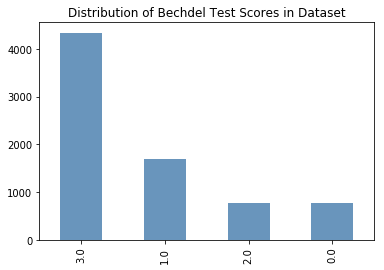

In [91]:
bechdel_df.score.value_counts().plot(kind='bar', color='#6995BC', title='Distribution of Bechdel Test Scores in Dataset');

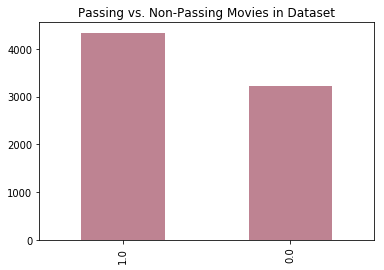

In [92]:
bechdel_df.passing.value_counts().plot(kind='bar', color='#BE8392', title='Passing vs. Non-Passing Movies in Dataset');

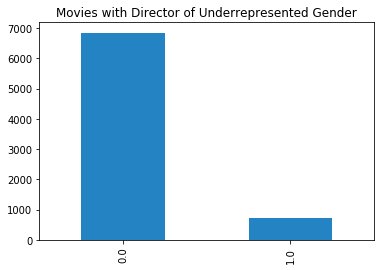

In [94]:
bechdel_df.director.value_counts().plot(kind='bar', color='#2383C3', title='Movies with Director of Underrepresented Gender');

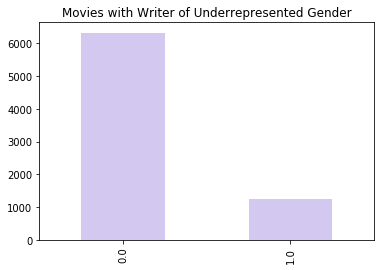

In [96]:
bechdel_df.writer.value_counts().plot(kind='bar', color='#D3C9F0', title='Movies with Writer of Underrepresented Gender');

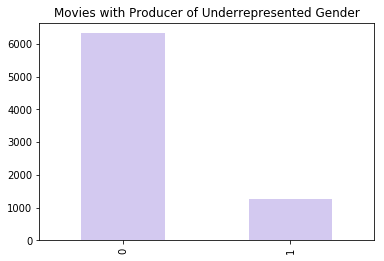

In [97]:
bechdel_df.producer.value_counts().plot(kind='bar', color='#D3C9F0', title='Movies with Producer of Underrepresented Gender');

#### Movies in the Dataset by Year

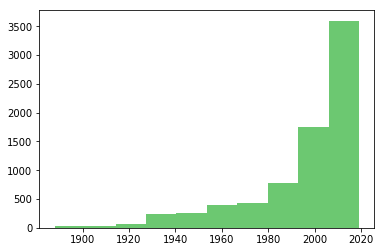

In [102]:
plt.hist(bechdel_df.year, color='#6CC871');

#### Violin Plots for Visualizing Differences in Passing vs. Non-Passing Movies compared to other Features

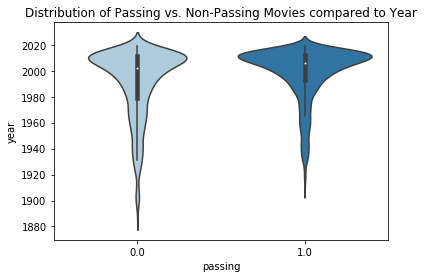

In [98]:
sns.set_palette('Paired')
sns.violinplot(x=bechdel_df.passing, y=bechdel_df.year).set_title('Distribution of Passing vs. Non-Passing Movies compared to Year');

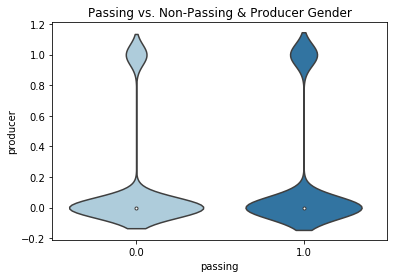

In [104]:
sns.violinplot(x=bechdel_df.passing, y=bechdel_df.producer).set_title('Passing vs. Non-Passing & Producer Gender');

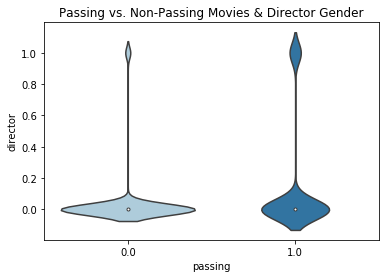

In [103]:
sns.violinplot(x=bechdel_df.passing, y=bechdel_df.director).set_title('Passing vs. Non-Passing Movies & Director Gender');

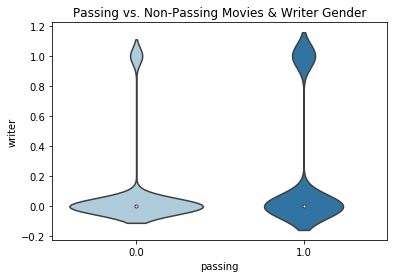

In [105]:
sns.violinplot(x=bechdel_df.passing, y=bechdel_df.writer).set_title('Passing vs. Non-Passing Movies & Writer Gender');

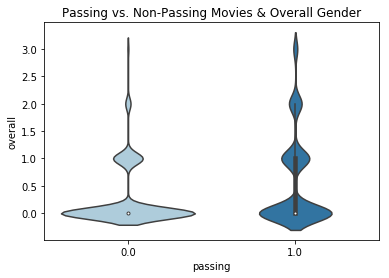

In [106]:
sns.violinplot(x=bechdel_df.passing, y=bechdel_df.overall).set_title('Passing vs. Non-Passing Movies & Overall Gender');

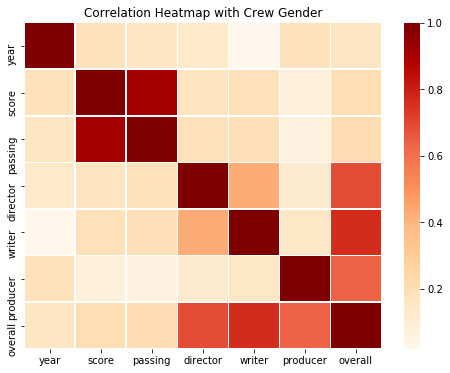

In [109]:
plt.figure(figsize=(8,6))
sns.heatmap(bechdel_df.corr(), linewidths=0.5, cmap="OrRd").set_title('Correlation Heatmap with Crew Gender');

The main observation from the above heatmap seems to be that producer has the lowest correlation with a passing score out of any of the crew roles. 

In [2]:
bechdel_budget_revenue = pd.read_csv('my_data/non_zero_budgets_revenues_3.csv')
bechdel_budget_revenue.head()

,year,title,score,passing,imdb_id,director_gender,writer_gender,producer_gender,overall_gender,budget_millions,revenue_millions
0,2019.0,alita: battle angel,3.0,1.0,tt0437086,0.0,1.0,0,1.0,170.0,359.700000
1,2018.0,a quiet place,1.0,0.0,tt6644200,0.0,0.0,0,0.0,17.0,340.939361
2,2018.0,a simple favor,3.0,1.0,tt7040874,0.0,1.0,1,2.0,20.0,42.600000
3,2018.0,a star is born,3.0,1.0,tt1517451,0.0,1.0,0,1.0,36.0,403.588149
4,2018.0,a wrinkle in time,3.0,1.0,tt1620680,1.0,1.0,1,3.0,100.0,132.675864


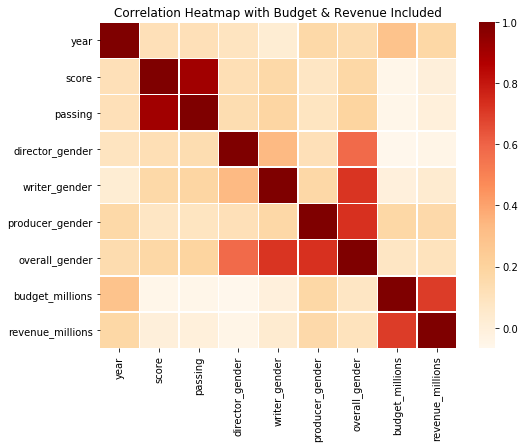

In [111]:
plt.figure(figsize=(8,6))
sns.heatmap(bechdel_budget_revenue.corr(), linewidths=0.5, cmap="OrRd").set_title('Correlation Heatmap with Budget & Revenue Included');

The budget and revenue dataset is smaller than the overall Bechdel Test dataset, with only non-zero budget and revenue values. Budget and revenue have a lower correlation with a passing score than the crew genders, with revenue having a slightly higher correlation than budget. Regarding crew gender, this smaller subset of the data mirrors the lowest correlation between a passing movie and producer gender seen in the larger dataset. 

#### Violin Plots with Budget & Revenue

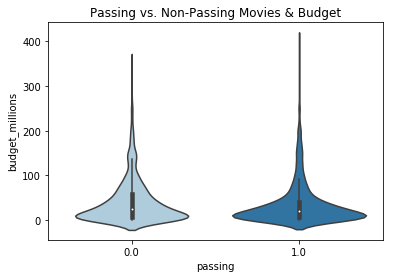

In [113]:
sns.violinplot(x=bechdel_budget_revenue.passing, y=bechdel_budget_revenue.budget_millions).set_title('Passing vs. Non-Passing Movies & Budget');

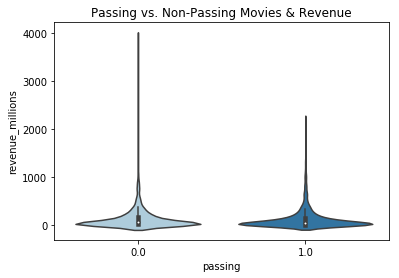

In [114]:
sns.violinplot(x=bechdel_budget_revenue.passing, y=bechdel_budget_revenue.revenue_millions).set_title('Passing vs. Non-Passing Movies & Revenue');

In [117]:
gender_columns = bechdel_df.columns[4:]

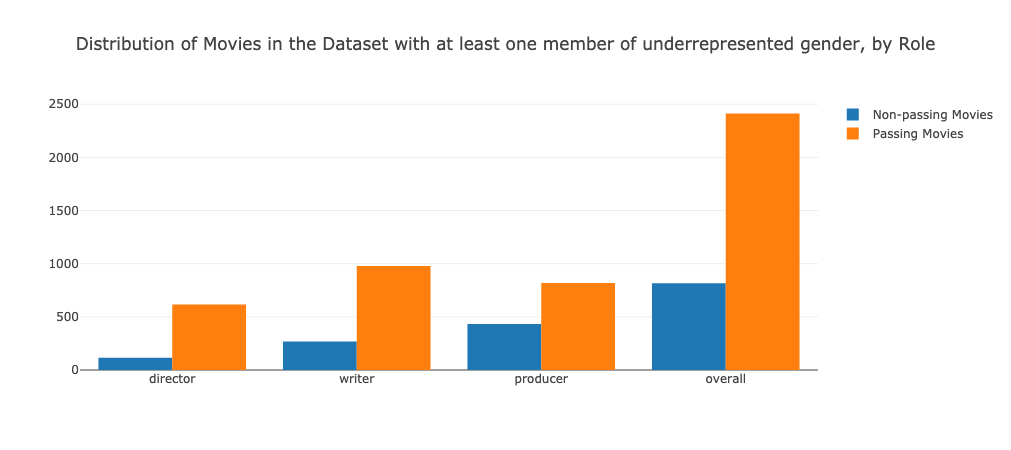

In [118]:
trace0 = go.Bar(
    x=[col for col in gender_columns],
    y=[val for val in bechdel_df.groupby('passing')[gender_columns].sum().values[0]],
    name='Non-passing Movies'
)

trace1 = go.Bar(
    x=[col for col in gender_columns],
    y=[val for val in bechdel_df.groupby('passing')[gender_columns].sum().values[1]],
    name='Passing Movies'
)
data = [trace0, trace1]    

layout = go.Layout(
    title="Distribution of Movies in the Dataset with at least one member of underrepresented gender, by Role",
    barmode=('group')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [3]:
mean_median_budget = bechdel_budget_revenue.groupby('passing').budget_millions.agg(['mean', 'median'])
mean_median_budget

,mean,median
passing,,
0.0,40.940761,25.0
1.0,35.808432,20.0


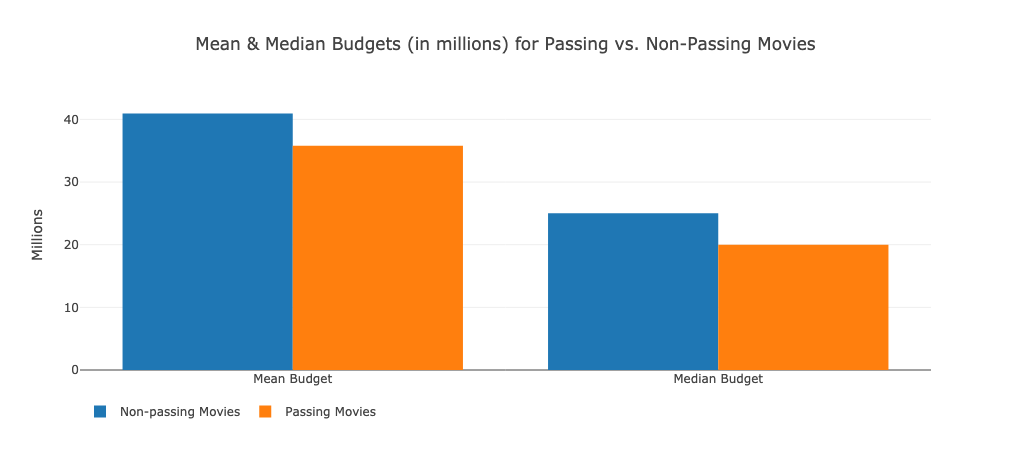

In [4]:
trace0 = go.Bar(
    x=['Mean Budget', 'Median Budget'],
    y=[val for val in mean_median_budget.values[0]],
    name='Non-passing Movies'    
)

trace1 = go.Bar(
    x=['Mean Budget', 'Median Budget'],
    y=[val for val in mean_median_budget.values[1]],
    name='Passing Movies'    
)

data = [trace0, trace1]    
layout = go.Layout(
    title="Mean & Median Budgets (in millions) for Passing vs. Non-Passing Movies", 
    yaxis=dict(title="Millions"),
    barmode='group',
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [5]:
mean_median_revenue = bechdel_budget_revenue.groupby('passing').revenue_millions.agg(['mean', 'median'])
mean_median_revenue

,mean,median
passing,,
0.0,131.341806,58.346148
1.0,129.565511,51.842679


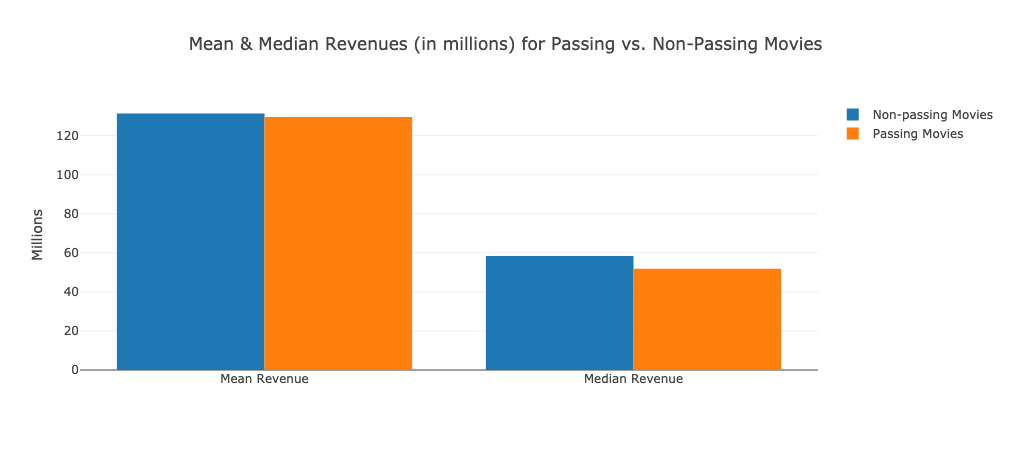

In [123]:
trace0 = go.Bar(
    x=['Mean Revenue', 'Median Revenue'],
    y=[val for val in mean_median_revenue.values[0]],
    name='Non-passing Movies'    
)

trace1 = go.Bar(
    x=['Mean Revenue', 'Median Revenue'],
    y=[val for val in mean_median_revenue.values[1]],
    name='Passing Movies'    
)

data = [trace0, trace1]    
layout = go.Layout(
    title="Mean & Median Revenues (in millions) for Passing vs. Non-Passing Movies", 
    yaxis=dict(title="Millions"),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

##### The budget and revenue plots above show a much greater difference in budget between passing and non-passing movies than in revenue.

### B. Oscar Nominees

#### Visualize total nominees by gender

In [46]:
print(oscar_nominees.year.min())
print(oscar_nominees.year.max())

1929
2019


In [47]:
oscar_nominees.gender.value_counts()

male          8543
female        1025
non-binary       1
Name: gender, dtype: int64

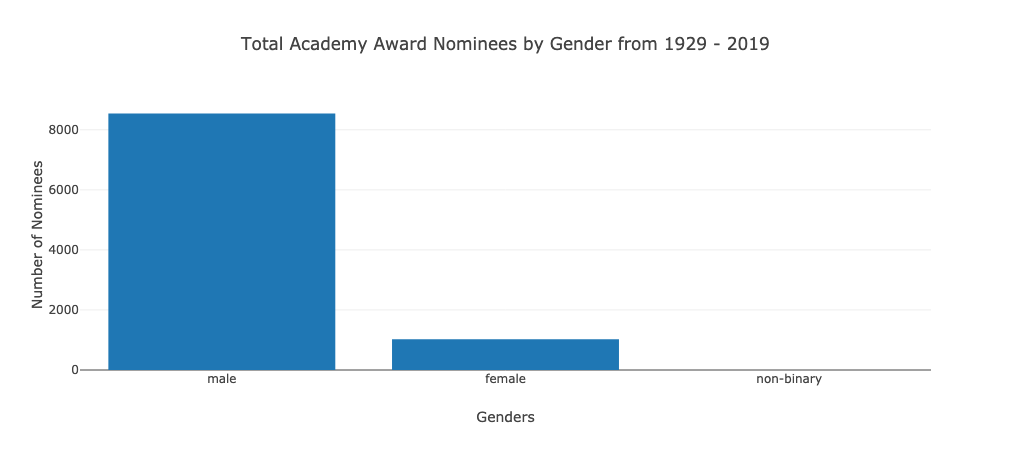

In [45]:
trace = go.Bar(
            x=["male", "female", "non-binary"],
            y=[oscar_nominees.gender.value_counts()["male"],
               oscar_nominees.gender.value_counts()["female"],
               oscar_nominees.gender.value_counts()["non-binary"]
              ]
)
data = [trace]    
layout = go.Layout(title="Total Academy Award Nominees by Gender from 1929 - 2019",
                   xaxis=dict(title="Genders"), 
                   yaxis=dict(title="Number of Nominees"))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Visualize Gender Counts of Oscar Nominees by Year

In [49]:
male_nominees = oscar_nominees.loc[oscar_nominees.gender == 'male']
female_nominees = oscar_nominees.loc[oscar_nominees.gender == 'female']
non_binary_nominees = oscar_nominees.loc[oscar_nominees.gender == 'non-binary']

Create lists for y-values of number of nominees for each gender for each year. Check to see if any person of that gender was nominated in each year to avoid throwing errors.

In [50]:
male_counts = []
female_counts = []
non_binary_counts = []

for y in oscar_nominees.year.unique():
    if y in male_nominees.year.values:
        male_counts.append(male_nominees.year.value_counts()[y])
    else:
        male_counts.append(0)
    if y in female_nominees.year.values:
        female_counts.append(female_nominees.year.value_counts()[y])
    else:
        female_counts.append(0)
    if y in non_binary_nominees.year.values:
        non_binary_counts.append(non_binary_nominees.year.value_counts()[y])
    else:
        non_binary_counts.append(0)

Check accuracy

In [51]:
print(f'Total male nominees: {np.sum(male_counts)}')
print(f'Total female nominees: {np.sum(female_counts)}')
print(f'Total non-binary nominees: {np.sum(non_binary_counts)}')

Total male nominees: 8543
Total female nominees: 1025
Total non-binary nominees: 1


In [52]:
oscar_nominees.gender.value_counts()

male          8543
female        1025
non-binary       1
Name: gender, dtype: int64

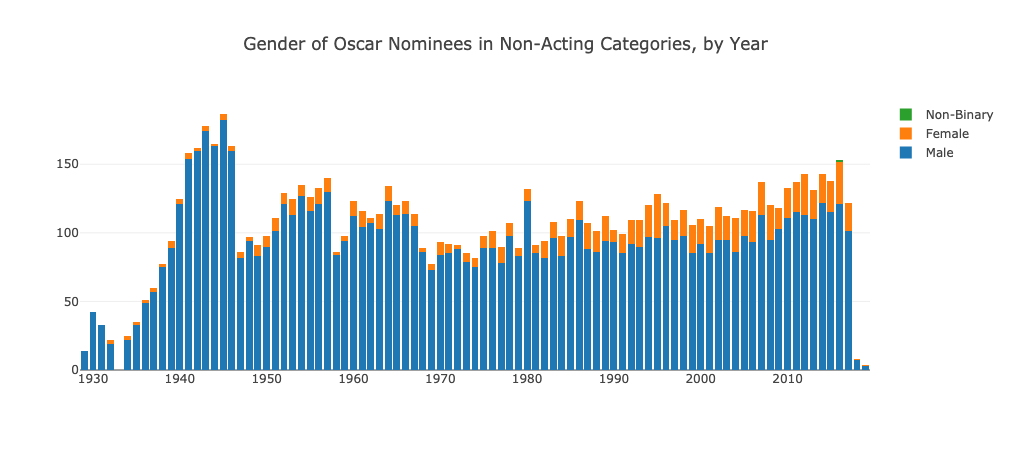

In [53]:
years = oscar_nominees.year.unique()
y_gender_values = [male_counts, female_counts, non_binary_counts]

trace1 = go.Bar(
    x=years,
    y=y_gender_values[0],
    name="Male"
)
trace2 = go.Bar(
    x=years,
    y=y_gender_values[1],
    name="Female"
)

trace3 = go.Bar(
    x=years,
    y=y_gender_values[2],
    name="Non-Binary"
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='stack',
    title="Gender of Oscar Nominees in Non-Acting Categories, by Year"
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Investigate year with no nominees

In [55]:
sorted(oscar_nominees.year.unique())

[1929,
 1930,
 1931,
 1932,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

There was an Awards ceremony held in 1933 - the 6th Annual Academy Awards - and there was also one female winner out of two female nominees in writing categories. For some reason, this ceremony did not appear in the Wikidata query, so will need to be added manually at a later time to improve accuracy of the data and analysis. 

### Data taken from Women's Media Center Report on the 2019 Academy Awards

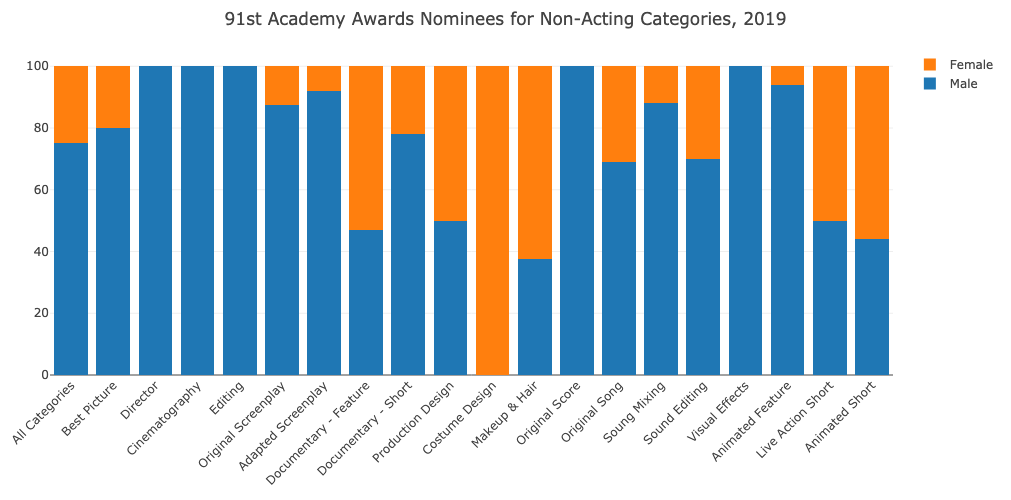

In [165]:
categories = ["All Categories", "Best Picture", "Director", "Cinematography", "Editing",
             "Original Screenplay", "Adapted Screenplay", "Documentary - Feature", "Documentary - Short", "Production Design",
             "Costume Design", "Makeup & Hair", "Original Score", "Original Song", "Soung Mixing", "Sound Editing",
             "Visual Effects", "Animated Feature", "Live Action Short", "Animated Short"]

y_male = [75,80,100,100,100,87.5,92,47,78,50,0,37.5,100,69,88,70,100,94,50,44]
y_female = [25,20,0,0,0,12.5,8,53,22,50,100,62.5,0,31,12,30,0,6,50,56]

trace1 = go.Bar(x=categories, y=y_male, name="Male")
trace2 = go.Bar(x=categories, y=y_female, name="Female")

# trace3 = go.Scatter(x=categories, 
#                     y=[50], 
#                     name="50% Mark",
#                     text="50%",
#                     line=dict(
#                     color="rgb(0,0,0)")
#                     )

data = [trace1, trace2]

layout = go.Layout(
    title="91st Academy Awards Nominees for Non-Acting Categories, 2019",
    barmode= "stack",
    xaxis = dict(
        tickangle=-45
    ),
#     shapes=[
#         {
#         "type": "line",
#         "y0":50,
#         "x0":"All Categories",
#         "y1":50,
#         "x1":"Animated Short",
#             "line": {
#                 "dash":"dot",
#                 "color":"black"
#             }
#         }
#     ],
    autosize=False,
    width=1000,
    height=500,
    margin = go.layout.Margin(
        l=50,
        r=50,
        t=50,
        b=125
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## III. Conditional Probability with Bayes Theorem

### A. Probability of Randomly Selected Film Passing from this Dataset

In [73]:
df = pd.read_csv('my_data/condensed_bechdel_7.csv')
df.head()

,year,title,passing,director,writer,producer,overall
0,2019.0,Alita: Battle Angel,1,0.0,1.0,0,1.0
1,2019.0,Close,1,1.0,1.0,0,2.0
2,2019.0,Cold Pursuit,0,0.0,0.0,0,0.0
3,2019.0,The Kid Who Would Be King,0,0.0,0.0,1,1.0
4,2019.0,Polar,0,0.0,0.0,0,0.0


In [74]:
passing_count = len(df.query('passing == 1'))
passing_count

4340

In [83]:
passing_proba = passing_count/len(df)
passing_proba = round((passing_proba * 100),2)
passing_proba

57.32

#### Demonstrate probability of randomly selected film passing with random sampling
* 1000 samples of dataset with replacement
* sample size n = 100

In [ ]:
df = pd.read_csv('')

In [84]:
sample_passing = []
for i in range(1000):
    sample = df.sample(n=100, replace=True)
    passing = sample.passing.value_counts()[1]
    sample_passing.append(passing)

print(f'The mean passing value of 1000 samples is {np.mean(sample_passing)}')

The mean passing value of 1000 samples is 57.197


### B. Conditional Probability, Bayes Theorem, & Likelihood
Visualizations have shown that films with a director, writer, and/or producer of an underrepresented gender are more likely to pass the Test </br>
P(A|B) = P(A) * P(B|A) / P(B)

P(A) = Probability of a film passing the Bechdel Test for this dataset </br>
P(B) = Probability of a film having a director of an underrepresented gender </br>
P(C) = Probability of a film having a writer of an underrepresented gender </br>
P(D) = Probability of a film having a producer of an underrepresented gender

In [124]:
director_proba = round((df.director.value_counts()[1] / len(df)),2)
director_proba

0.1

In [125]:
writer_proba = round((df.writer.value_counts()[1] / len(df)), 2)
writer_proba

0.16

In [127]:
producer_proba = round((df.producer.value_counts()[1] / len(df)), 2)
producer_proba

0.17

P(A) = 0.57 </br>
P(B) = 0.1 </br>
P(C) = 0.16 </br>
P(D) = 0.17

#### Likelihood
P(B|A) = probability of director of underrepresented gender, given a passing test </br>
P(C|A) = probability of writer of underrepresented gender, given a passing test </br>
P(D|A) = probability of producer of underrepresented gender, given a passing test </br>

In [128]:
passing_movies = df.loc[df.passing == 1]
passing_movies.head()

,year,title,passing,director,writer,producer,overall
0,2019.0,Alita: Battle Angel,1,0.0,1.0,0,1.0
1,2019.0,Close,1,1.0,1.0,0,2.0
6,2018.0,6 Balloons,1,1.0,1.0,0,2.0
9,2018.0,A Simple Favor,1,0.0,1.0,1,2.0
10,2018.0,A Star Is Born,1,0.0,1.0,0,1.0


In [129]:
passing_movies.shape

(4340, 7)

In [130]:
director_proba_with_passing = round((passing_movies.director.value_counts()[1] / len(passing_movies)),2)
director_proba_with_passing

0.14

In [131]:
writer_proba_with_passing = round((passing_movies.writer.value_counts()[1] / len(passing_movies)), 2)
writer_proba_with_passing

0.23

In [133]:
producer_proba_with_passing = round((passing_movies.producer.value_counts()[1] / len(passing_movies)), 2)
producer_proba_with_passing

0.19

P(B|A) = 0.14 </br>
P(C|A) = 0.22 </br>
P(D|A) = 0.19

In [151]:
proba_passing_with_director = (0.57 * 0.14) / 0.1
proba_passing_with_director = round(proba_passing_with_director,2)
proba_passing_with_director

0.8

In [152]:
proba_passing_with_writer = (0.57 * 0.22) / 0.16
proba_passing_with_writer = round(proba_passing_with_writer,2)
proba_passing_with_writer

0.78

In [153]:
proba_passing_with_producer = (0.57 * 0.19) / 0.17
proba_passing_with_producer = round(proba_passing_with_producer,2)
proba_passing_with_producer

0.64

P(A|B) = probability of passing test, given director of underrepresented gender = 0.8 </br>
P(A|C) = probability of passing test, given writer of underrepresented gender = 0.78 </br>
P(A|D) = probability of passing test, given producer of underrepresented gender = 0.64

#### Calculate probability of a passing test, given no crew members of underrepresented gender
P(A|E) = probability of passing test, given no director of underrepresented gender </br>
P(A|F) = probability of passing test, given no writer of underrepresented gender </br>
P(A|G) = probability of passing test, given no producer of underrepresented gender

In [ ]:
# P(A|E) = P(A) * P(E|A) / P(E)

In [140]:
# P(E)
no_director_proba = round((df.director.value_counts()[0] / len(df)),2)
print(no_director_proba)
print(1 - director_proba)

0.9
0.9


In [138]:
# P(E|A)
no_director_proba_with_passing = round((passing_movies.director.value_counts()[0] / len(passing_movies)),2)
no_director_proba_with_passing

0.86

In [154]:
proba_passing_with_no_director = (0.57 * 0.86) / 0.9
proba_passing_with_no_director = round(proba_passing_with_no_director,2)
proba_passing_with_no_director

0.54

In [141]:
# P(A|F) = P(A) * P(F|A) / P(F)

In [142]:
# P(F)
no_writer_proba = 1 - writer_proba
no_writer_proba

0.84

In [146]:
# P(F|A) 
no_writer_proba_with_passing = round((passing_movies.writer.value_counts()[0] / len(passing_movies)),2)
no_writer_proba_with_passing

0.77

In [155]:
proba_passing_with_no_writer = (0.57 * 0.77) / 0.84
proba_passing_with_no_writer = round(proba_passing_with_no_writer,2)
proba_passing_with_no_writer

0.52

In [ ]:
# P(A|G) = P(A) * P(G|A) / P(G)

In [145]:
# P(G)
no_producer_proba = 1 - producer_proba
no_producer_proba

0.83

In [148]:
# P(G|A)
no_producer_proba_with_passing = round((passing_movies.producer.value_counts()[0] / len(passing_movies)),2)
no_producer_proba_with_passing

0.81

In [156]:
proba_passing_with_no_producer = (0.57 * 0.81) / 0.83
proba_passing_with_no_producer = round(proba_passing_with_no_producer,2)
proba_passing_with_no_producer

0.56

P(A|E) = passing with no director of underrepresented gender = 0.54 </br>
P(A|F) = passing with no writer of underrepresented gender = 0.52 </br>
P(A|G) = passing with no producer of underrepresented gender = 0.56

#### Check out probabilities with actual scores out of entire dataset

In [162]:
random_df_sample = df.sample(n=5)
random_df_sample

,year,title,passing,director,writer,producer,overall
2704,2009.0,Knowing,0,0.0,0.0,0,0.0
4596,1999.0,"Girl, Interrupted",1,0.0,1.0,1,2.0
3108,2007.0,Arranged,1,1.0,0.0,0,1.0
7538,2012.0,Wireboy,0,1.0,1.0,1,3.0
6272,1973.0,American Graffiti,0,0.0,1.0,0,1.0


In [163]:
knowing_proba = proba_passing_with_no_director * proba_passing_with_no_writer * proba_passing_with_producer
girl_int_proba = proba_passing_with_no_director * proba_passing_with_writer * proba_passing_with_producer
arranged_proba = proba_passing_with_director * proba_passing_with_no_writer * proba_passing_with_no_producer
wireboy_proba = proba_passing_with_director * proba_passing_with_writer * proba_passing_with_producer
american_graffiti_proba = proba_passing_with_no_director * proba_passing_with_writer * proba_passing_with_no_producer

print(f'{round(knowing_proba,2)} probability of Knowing passing')
print(f'{round(girl_int_proba,2)} probability of Girl, Interrupted passing')
print(f'{round(arranged_proba,2)} probability of Arranged passing')
print(f'{round(wireboy_proba,2)} probability of Wireboy passing')
print(f'{round(american_graffiti_proba,2)} probability of American Graffiti passing')

0.18 probability of Knowing passing
0.27 probability of Girl, Interrupted passing
0.23 probability of Arranged passing
0.4 probability of Wireboy passing
0.24 probability of American Graffiti passing


Interested to see what Wireboy is - according to IMDB, it's a film short with no named characters at all, male or female. So would not have even scored one point on the Bechdel Test. 

## IV. Hypothesis Testing

### Hypothesis 1
* H0 - There is no statistically significant difference between the budgets of films that pass the Bechdel Test and films that do not pass the Bechdel Test. </br>
    * $H_0$: $\mu_1$ = $\mu_2$
* H1 - There is a statistically significant difference bettween the budgets of films that pass the Bechdel Test and films that do not pass the Bechdel Test.
    * $H_a$: $\mu_1$ $\neq$ $\mu_2$  

#### Budget Distributions

In [9]:
import plotly.figure_factory as ff

In [6]:
passing_movies = budget_revenue_df.query('passing == 1')
passing_movies.shape

NameError: name 'budget_revenue_df' is not defined

In [12]:
non_passing_movies = budget_revenue_df.query('passing == 0')
non_passing_movies.shape

(1595, 12)

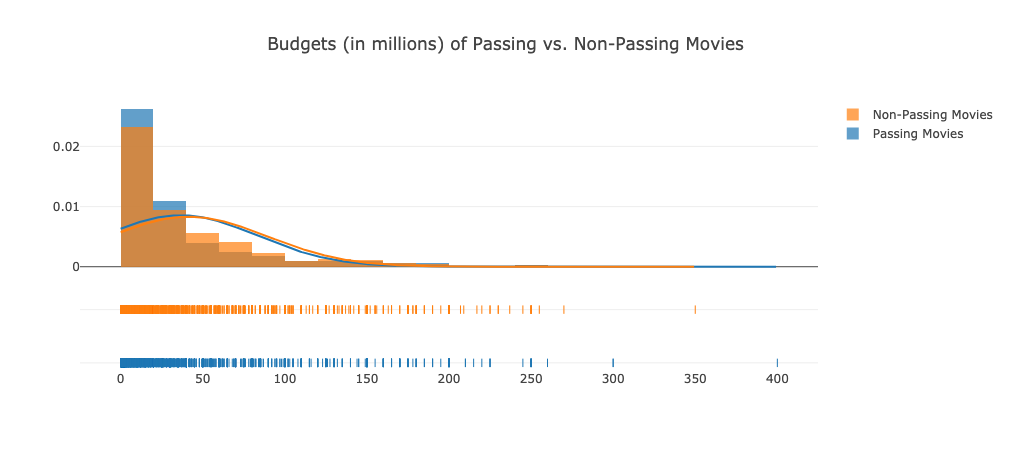

In [28]:
x1 = passing_movies.budget_millions
x2 = non_passing_movies.budget_millions

hist_data = [x1, x2]
labels = ['Passing Movies', 'Non-Passing Movies']

fig = ff.create_distplot(hist_data, labels, curve_type='normal', bin_size=20)
fig['layout'].update(title='Budgets (in millions) of Passing vs. Non-Passing Movies')
iplot(fig)

In [20]:
from scipy import stats

In [21]:
x1_mu = passing_movies.budget_millions.mean()
x2_mu = non_passing_movies.budget_millions.mean()

x1_var = passing_movies.budget_millions.std()
x2_var = non_passing_movies.budget_millions.std()

print(f'Mean budget of passing movies: {x1_mu}')
print(f'Mean budget of non-passing movies: {x2_mu}')
print(f'Variance in budgets of passing movies: {x1_var}')
print(f'Variance in budgets on non-passing movies: {x2_var}')

Mean budget of passing movies: 36.34017572452731
Mean budget of non-passing movies: 41.38629381065831
Variance in budgets of passing movies: 46.648005131918026
Variance in budgets on non-passing movies: 48.03875617001384


In [30]:
# Check log-normal distributions

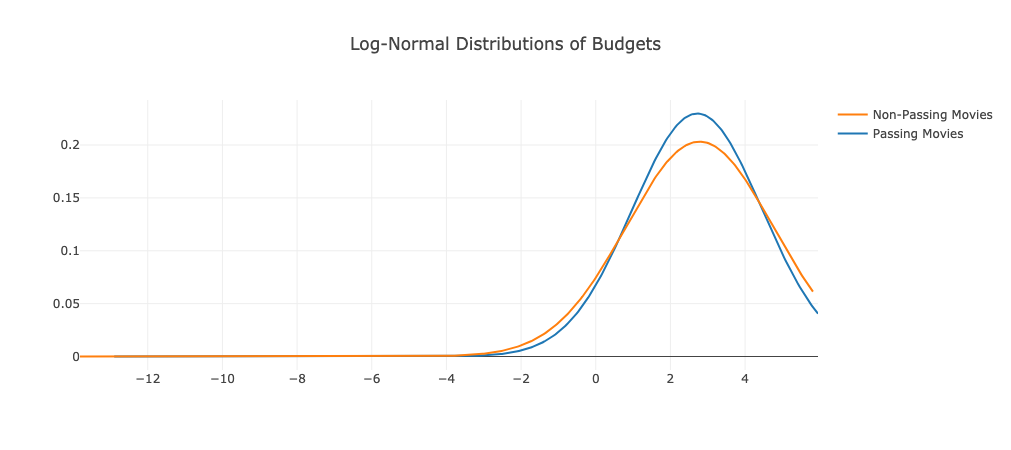

In [31]:
x1 = passing_movies.budget_millions
x2 = non_passing_movies.budget_millions

hist_data = [np.log(x1), np.log(x2)]
labels = ['Passing Movies', 'Non-Passing Movies']

fig = ff.create_distplot(hist_data, labels, curve_type='normal', show_hist=False, show_rug=False, bin_size=20)
fig['layout'].update(title='Log-Normal Distributions of Budgets')
iplot(fig)

In [33]:
t,p = stats.ttest_ind(x1, x2)
if p < 0.05:
    print(f'With a p-value of {p}, the null hypothesis that there is no statistically significant difference in the budgets \
    of passing vs. non-passing movies can be rejected.')
else:
    print(f'With a p-value of {p}, the null hypothesis that there is no statistically significant difference in the budgets \
    of passing vs. non-passing movies cannot be rejected.')

With a p-value of 0.0016815624295128007, the null hypothesis that there is no statistically significant difference in the budgets     of passing vs. non-passing movies can be rejected.


### Hypothesis 2
* H0 - There is no statistically significant difference between the revenues of films that pass the Bechdel Test and films that do not pass the Bechdel Test. </br>
    * $H_0$: $\mu_1$ = $\mu_2$
* H2 - There is a statistically significant difference bettween the revenues of films that pass the Bechdel Test and films that do not pass the Bechdel Test.
    * $H_a$: $\mu_1$ $\neq$ $\mu_2$  

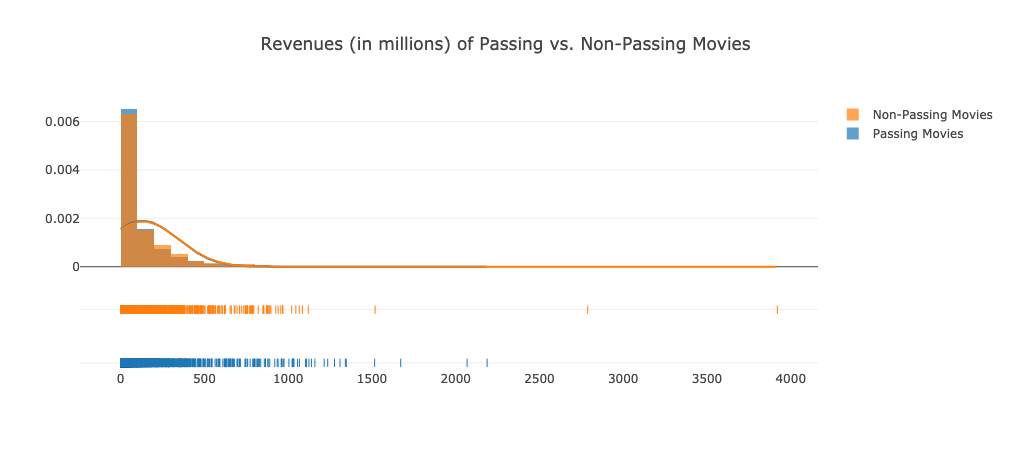

In [37]:
x1 = passing_movies.revenue_millions
x2 = non_passing_movies.revenue_millions

hist_data = [x1, x2]
labels = ['Passing Movies', 'Non-Passing Movies']

fig = ff.create_distplot(hist_data, labels, curve_type='normal', bin_size=100)
fig['layout'].update(title='Revenues (in millions) of Passing vs. Non-Passing Movies')
iplot(fig)

In [38]:
x1_mu = passing_movies.revenue_millions.mean()
x2_mu = non_passing_movies.revenue_millions.mean()

x1_var = passing_movies.revenue_millions.std()
x2_var = non_passing_movies.revenue_millions.std()

print(f'Mean revenue of passing movies: {x1_mu}')
print(f'Mean revenue of non-passing movies: {x2_mu}')
print(f'Variance in revenues of passing movies: {x1_var}')
print(f'Variance in revenues on non-passing movies: {x2_var}')

Mean revenue of passing movies: 130.4792080787374
Mean revenue of non-passing movies: 132.89137380077995
Variance in revenues of passing movies: 210.3555686553133
Variance in revenues on non-passing movies: 213.36499951256891


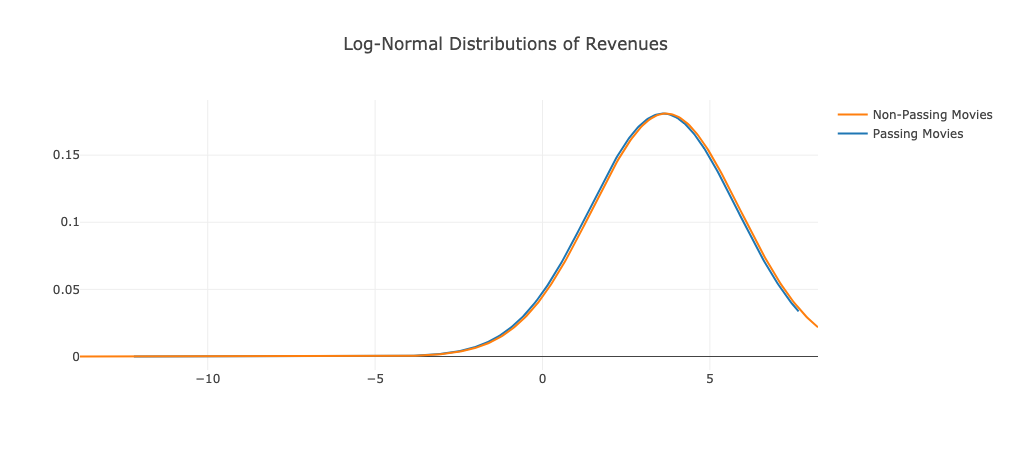

In [39]:
x1 = passing_movies.revenue_millions
x2 = non_passing_movies.revenue_millions

hist_data = [np.log(x1), np.log(x2)]
labels = ['Passing Movies', 'Non-Passing Movies']

fig = ff.create_distplot(hist_data, labels, curve_type='normal', show_hist=False, show_rug=False, bin_size=20)
fig['layout'].update(title='Log-Normal Distributions of Revenues')
iplot(fig)

In [40]:
t,p = stats.ttest_ind(x1, x2)
if p < 0.05:
    print(f'With a p-value of {p}, the null hypothesis that there is no statistically significant difference in the revenues \
    of passing vs. non-passing movies can be rejected.')
else:
    print(f'With a p-value of {p}, the null hypothesis that there is no statistically significant difference in the revenues \
    of passing vs. non-passing movies cannot be rejected.')

With a p-value of 0.737169786989613, the null hypothesis that there is no statistically significant difference in the revenues     of passing vs. non-passing movies cannot be rejected.


### Conclusion of Hypothesis Tests
Based on hypothesis testing for this dataset of 3499 movies with budget and revenue values, movies that pass the Bechdel Test have a lower average budget than movies that do not pass the Bechdel Test, but the different in revenue of these two groups of movies is not statistically significant. 

## V. Dashboard
* Visualize important insight & metrics
* Allow user to explore, customize, and extract the data that interests them

## VI. Conclusion

### A. Crowdsourced Data

## VII. Recommendations

### A. Existing Projects & Initiatives:
* Annenberg Inclusion Initiative - University of Southern California based think tank focused on diversity and inclusion in entertainment
* Women's Media Center - Nonpartisan and Non-profit organization founded by Jane Fonda, Robin Morgan and Gloria Steinem to raise awareness and take action on a wide range of issues affecting women and girls
* Geena Davis Institute on Gender & Media - "If she can see it, she can be it" - promotes increased visibility of women in media and in other roles, especially in roles where girls may not have seen much female representation
* Women in Media - Non-profit organization promoting gender balance in media by offering networking for female and female-identifying crew members

## VIII. Further Research

## Presentation and Dashboard Visualizations

### Financial Data from Forbes for Presentation

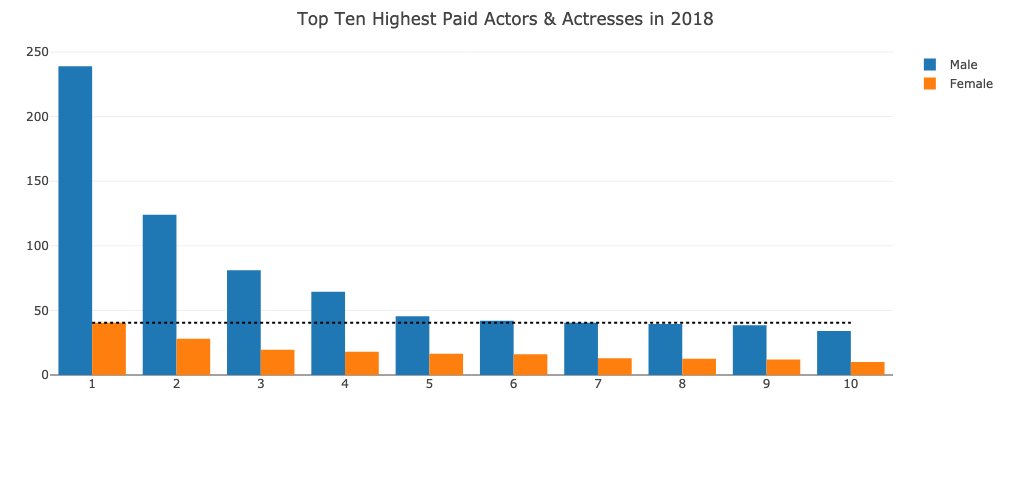

In [6]:
x = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

totals = [748.5, 168]

male_names = ["George Clooney", "Dwayne Johnson", "Robert Downey Jr.", "Chris Hemsworth", "Jackie Chan", "Will Smith", "Akshay Kumar",
            "Adam Sandler", "Salman Khan", "Chris Evans"]
male_salaries = [239, 124, 81, 64.5, 45.5, 42, 40.5, 39.5, 38.5, 34]

female_names = ["Scarlett Johansson", "Angelina Jolie", "Jennifer Aniston", "Jennifer Lawrence", "Reese Witherspoon", 
                "Mila Kunis", "Julia Roberts", "Cate Blanchett", "Melissa McCarthy", "Gal Gadot", "Total"]
female_salaries = [40.5, 28, 19.5, 18, 16.5, 16, 13, 12.5, 12, 10]

trace1 = go.Bar(x=x, y=male_salaries, name="Male")
# trace2 = go.Bar(x=x, y=male_salaries, name=male_names)

trace3 = go.Bar(x=x, y=female_salaries, name="Female")
# trace4 = go.Bar(x=2, y=female_salaries[1], name=female_names[1])
# trace1 = go.Bar(x=x, y=male_salaries, name="Men", text=male_names)
# trace2 = go.Bar(x=x, y=female_salaries, name="Women", text=female_names)

data = [trace1, trace3]

layout = go.Layout(
    title="Top Ten Highest Paid Actors & Actresses in 2018", 
    xaxis = dict(
        #tickangle=-45,
        showticklabels=True,
        type="category"),
    autosize=False,
    width=1000,
    height=500,
    margin = go.layout.Margin(
        l=50,
        r=50,
        t=50,
        b=125
    ),
        shapes=[
        {
        "type": "line",
        "y0":40.5,
        "x0":"1",
        "y1":40.5,
        "x1":"10",
            "line": {
                "dash":"dot",
                "color":"black"
            }
        }
    ],
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

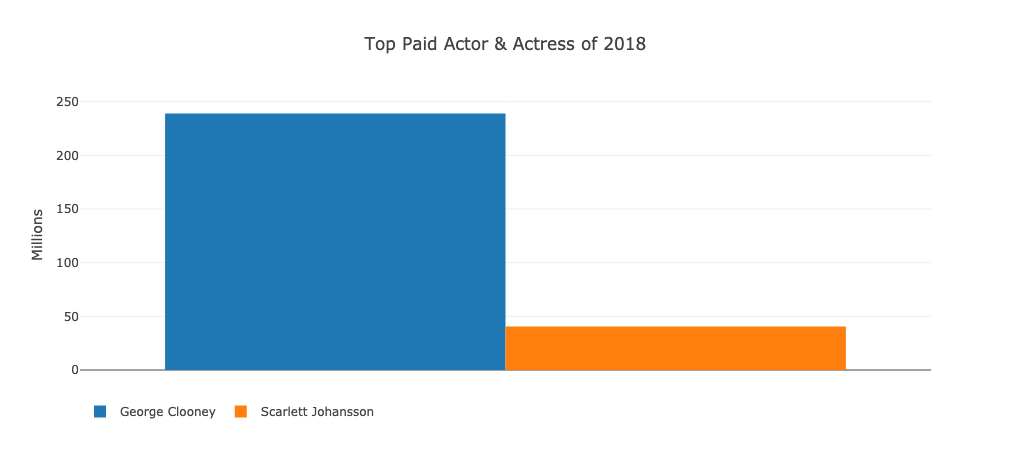

In [10]:
x = [1]
y_george = [239]
y_scarlett = [40.5]

trace1 = go.Bar(x=x, y=y_george, name="George Clooney")
trace2 = go.Bar(x=x, y=y_scarlett, name="Scarlett Johansson")

data = [trace1, trace2]

layout = go.Layout(
    title="Top Paid Actor & Actress of 2018",
    xaxis = dict(
        #tickangle=-45,
        showticklabels=False,
    ),
    yaxis = dict(
        title="Millions"
    ),
    width=500,
    autosize=False,
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [7]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#### WordCloud for Presentation

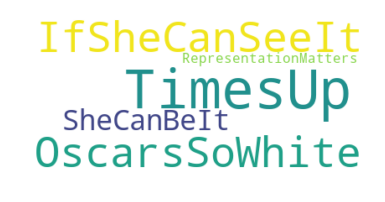

In [30]:
# ?WordCloud
stopwords = "and"
hash_tags = "#TimesUp #OscarsSoWhite #IfSheCanSeeIt #SheCanBeIt #RepresentationMatters"

wordcloud = WordCloud(background_color="white").generate(hash_tags)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
df = pd.read_csv('my_data/non_zero_budgets_revenues_3.csv')
df.head()

,year,title,score,passing,imdb_id,director_gender,writer_gender,producer_gender,overall_gender,budget_millions,revenue_millions
0,2019.0,alita: battle angel,3.0,1.0,tt0437086,0.0,1.0,0,1.0,170.0,359.700000
1,2018.0,a quiet place,1.0,0.0,tt6644200,0.0,0.0,0,0.0,17.0,340.939361
2,2018.0,a simple favor,3.0,1.0,tt7040874,0.0,1.0,1,2.0,20.0,42.600000
3,2018.0,a star is born,3.0,1.0,tt1517451,0.0,1.0,0,1.0,36.0,403.588149
4,2018.0,a wrinkle in time,3.0,1.0,tt1620680,1.0,1.0,1,3.0,100.0,132.675864


In [12]:
at_least_one_female = df.loc[df.overall_gender > 0]
no_females = df.loc[df.overall_gender == 0]

In [13]:
print(at_least_one_female.revenue_millions.mean())
print(no_females.revenue_millions.mean())

167.9414336064062
110.58826764595103


In [14]:
print(at_least_one_female.budget_millions.mean())
print(no_females.budget_millions.mean())

45.6731705
34.18075325562417


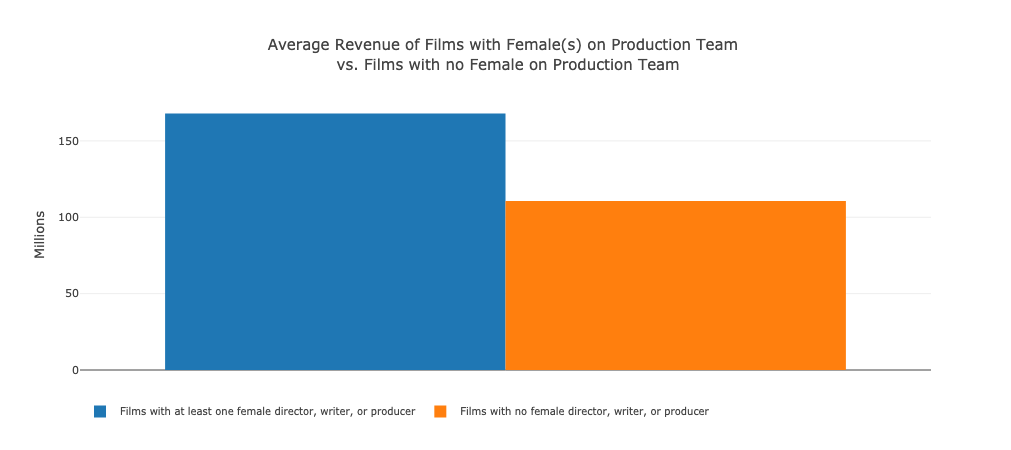

In [32]:
x = [1]
y_female = [at_least_one_female.revenue_millions.mean()]
y_no_female = [no_females.revenue_millions.mean()]

trace1 = go.Bar(x=x, y=y_female, name="Films with at least one female director, writer, or producer")
trace2 = go.Bar(x=x, y=y_no_female, name="Films with no female director, writer, or producer")

data = [trace1, trace2]

layout = go.Layout(
    title="Average Revenue of Films with Female(s) on Production Team <br> vs. Films with no Female on Production Team",
    font=dict(
        size=11
    ),
    xaxis = dict(
        #tickangle=-45,
        showticklabels=False,
    ),
    yaxis = dict(
        title="Millions"
    ),
    width=500,
    autosize=False,
    legend=dict(
        orientation="h",
        font=dict(
            size=10)
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Academy Awards Data
I don't think this data is completely accurate, especially for the earlier Academy Awards and categories that have changed or have changed names through the years, but this data was queried from crowdsourced Wikidata and is a good starting point. 

Goal: Slider for dashboard to examine Academy Award nominees by year / category / gender. 

In [2]:
oscars_df = pd.read_csv('my_data/cleaned_oscar_nominees.csv')
oscars_df.head()

,name,gender,nom_category,year
0,Charlie Chaplin,male,"Writing, Original Screenplay",1948
1,Charlie Chaplin,male,"Writing, Original Screenplay",1941
2,Peter Jackson,male,"Writing, Original Screenplay",1995
3,Michel Hazanavicius,male,"Writing, Original Screenplay",2012
4,Sylvester Stallone,male,"Writing, Original Screenplay",1977


In [3]:
oscars_df.shape

(9599, 4)

In [6]:
oscars_df.loc[oscars_df.year == 2000]

,name,gender,nom_category,year
191,M. Night Shyamalan,male,"Writing, Original Screenplay",2000
264,Paul Thomas Anderson,male,"Writing, Original Screenplay",2000
392,Charlie Kaufman,male,"Writing, Original Screenplay",2000
396,Mike Leigh,male,"Writing, Original Screenplay",2000
430,Alan Ball,male,"Writing, Original Screenplay",2000
699,M. Night Shyamalan,male,Director,2000
778,Spike Jonze,male,Director,2000
942,Sam Mendes,male,Director,2000
1026,John Irving,male,"Writing, Adapted Screenplay",2000
1168,Eric Roth,male,"Writing, Adapted Screenplay",2000


In [9]:
oscars_df.gender.isnull().value_counts()

False    9569
True       30
Name: gender, dtype: int64

In [10]:
# Wishlist for slider bar graphs

# x = categories for that year
# y = percentage of male nominees, percentage of female nominees, percentage of non-binary nominees